In [1]:
import numpy as np
import pandas as pd
import requests
import re
from itertools import compress
from functools import reduce

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from plotting import *
%matplotlib inline

/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Get the data

In [2]:
complexes = ["CB8-G3", "OA-G3", "OA-G6"]
replicates = range(0, 5)
systems = [i + "-" + str(j) for i in complexes for j in replicates]

## YANK

In [3]:
url = "https://raw.githubusercontent.com/MobleyLab/SAMPL6/update-sampling/host_guest/Analysis/SAMPLing/Data/reference_free_energies.csv"
s = requests.get(url).content
data = s.decode("utf-8").split("\n")

In [4]:
yank_dictionary = {}
for system in systems:
    yank_dictionary[system] = {}
    for line in data:
        fields = line.split(",")
        if re.match(system + "-DG", fields[0]):
            yank_dictionary[system]["y"] = [float(i) for i in fields[1:]]
        if re.match(system + "-n_energy_evaluations", fields[0]):
            yank_dictionary[system]["x"] = [float(i) for i in fields[1:]]


## APR

In [58]:
# This directory has extra sampling.
# prefix = '/home/dslochower/kirkwood/projects/SAMPLing/OA-cut9-extension/'

# This directory (in the local repository) has the data we submitted to the SAMPLing challenge.
prefix = "./OA/"

In [59]:
oa_g3_0_9 = np.genfromtxt(prefix + 'OA-G3-0-ti-quicker.log')
oa_g3_1_9 = np.genfromtxt(prefix + 'OA-G3-1-ti-quicker.log')
oa_g3_2_9 = np.genfromtxt(prefix + 'OA-G3-2-ti-quicker.log')
oa_g3_3_9 = np.genfromtxt(prefix + 'OA-G3-3-ti-quicker.log')
oa_g3_4_9 = np.genfromtxt(prefix + 'OA-G3-4-ti-quicker.log')

oa_g6_0_9 = np.genfromtxt(prefix + 'OA-G6-0-ti-quicker-more.log')
oa_g6_1_9 = np.genfromtxt(prefix + 'OA-G6-1-ti-quicker-more.log')
oa_g6_2_9 = np.genfromtxt(prefix + 'OA-G6-2-ti-quicker-more.log')
oa_g6_3_9 = np.genfromtxt(prefix + 'OA-G6-3-ti-quicker-more.log')
oa_g6_4_9 = np.genfromtxt(prefix + 'OA-G6-4-ti-quicker-more.log')

In [60]:
nines  = [oa_g3_0_9, oa_g3_1_9, oa_g3_2_9, oa_g3_3_9, oa_g3_4_9,
          oa_g6_0_9, oa_g6_1_9, oa_g6_2_9, oa_g6_3_9, oa_g6_4_9]

apr_dictionary = dict()
for index, system in enumerate(['OA-G3-0', 'OA-G3-1', 'OA-G3-2', 'OA-G3-3', 'OA-G3-4', \
                                'OA-G6-0', 'OA-G6-1', 'OA-G6-2', 'OA-G6-3', 'OA-G6-4']):


    apr_dictionary[system] = {}
    apr_dictionary[system]["x"] = (nines[index][:,3] + nines[index][:,6]) * 250
    apr_dictionary[system]["y"] = -1 * (nines[index][:,1] + nines[index][:,4] + nines[index][:,7])
    apr_dictionary[system]["y_sem"] = np.sqrt(nines[index][:,2]**2 + nines[index][:,5]**2)

In [61]:
prefix = './CB8/'

In [62]:
cb8_g3 = np.genfromtxt(prefix + 'cb8-g3.ti-block.converge.dat', dtype=str)
total_time = 2135000000

In [63]:
for system, line in zip(['CB8-G3-0', 'CB8-G3-1', 'CB8-G3-2', 'CB8-G3-3', 'CB8-G3-4',], cb8_g3):
    apr_dictionary[system] = {}
    apr_dictionary[system]["x"] = np.linspace(0, total_time, 100)
    apr_dictionary[system]["y"] = [float(i[:-1]) for i in line[1::2]]
    apr_dictionary[system]["y_sem"] = [float(i[:-1]) for i in line[2::2]]

## Truncate YANK to the end of APR sampling

In [64]:
apr_oa_g3_evaluations = apr_dictionary["OA-G3-0"]["x"][-1]
apr_oa_g6_evaluations = apr_dictionary["OA-G6-0"]["x"][-1]
apr_cb8_g3_evaluations = apr_dictionary["CB8-G3-0"]["x"][-1]

First, trim the YANK results to only those free energy predictions with fewer energy evaluations than the number of energy evaluations we used for APR.

In [65]:
yank_trim = dict()

for system in ['OA-G3-0', 'OA-G3-1', 'OA-G3-2', 'OA-G3-3', 'OA-G3-4']:
    yank_trim[system] = dict()
    yank_trim[system]["x"] = list(compress(yank_dictionary[system]["x"], yank_dictionary[system]["x"] < apr_oa_g3_evaluations))
    yank_trim[system]["y"] = list(compress(yank_dictionary[system]["y"], yank_dictionary[system]["x"] < apr_oa_g3_evaluations))
    
for system in ['OA-G6-0', 'OA-G6-1', 'OA-G6-2', 'OA-G6-3', 'OA-G6-4']:
    yank_trim[system] = dict()
    yank_trim[system]["x"] = list(compress(yank_dictionary[system]["x"], yank_dictionary[system]["x"] < apr_oa_g6_evaluations))
    yank_trim[system]["y"] = list(compress(yank_dictionary[system]["y"], yank_dictionary[system]["x"] < apr_oa_g6_evaluations))
    
for system in ['CB8-G3-0', 'CB8-G3-1', 'CB8-G3-2', 'CB8-G3-3', 'CB8-G3-4']:
    yank_trim[system] = dict()
    yank_trim[system]["x"] = list(compress(yank_dictionary[system]["x"], yank_dictionary[system]["x"] < apr_cb8_g3_evaluations))    
    yank_trim[system]["y"] = list(compress(yank_dictionary[system]["y"], yank_dictionary[system]["x"] < apr_cb8_g3_evaluations))    

In [66]:
systems = ['OA-G3-0', 'OA-G3-1', 'OA-G3-2', 'OA-G3-3', 'OA-G3-4',
          'OA-G6-0', 'OA-G6-1', 'OA-G6-2', 'OA-G6-3', 'OA-G6-4',
          'CB8-G3-0', 'CB8-G3-1', 'CB8-G3-2', 'CB8-G3-3', 'CB8-G3-4',]
for system in systems:
    yank_trim[system]["x"] = np.array(yank_trim[system]["x"])

Next, not every YANK run has a free energy estimate for the same number of energy evaluations, find the common energy evaluations among the five YANK runs, and keep only those so we can find the mean at *exactly* the same time point.

In [67]:
yank_common = dict()
for prefix in ["OA-G3", "OA-G6", "CB8-G3"]:
    systems = [prefix + "-" + str(j) for j in range(0, 5)]
    
    common_times = reduce(np.intersect1d, 
                      (yank_trim[f'{prefix}-0']["x"] , yank_trim[f'{prefix}-1']["x"] , 
                       yank_trim[f'{prefix}-2']["x"] , yank_trim[f'{prefix}-3']["x"] , 
                       yank_trim[f'{prefix}-4']["x"]))
    common_indices = [np.where(yank_trim[system]["x"].reshape(yank_trim[system]["x"].size, 1) == common_times)[1] 
                      for system in systems]
    longest = [len(yank_trim[system]["x"]) for system in systems]

    print(f"There are {[i for i in longest]} energy evaluations in each replicate below the maximum number of APR evaluations.")
    print(f"There are {len(common_times)} points common among the five replicates.")
   
    for index, system in enumerate(systems):
        yank_common[system] = dict()
        yank_common[system]["y"] = [yank_trim[system]["y"][i] for i in common_indices[index]]
        yank_common[system]["x"] = common_times

There are [990, 1019, 997, 1014, 966] energy evaluations in each replicate below the maximum number of APR evaluations.
There are 505 points common among the five replicates.
There are [816, 795, 826, 819, 809] energy evaluations in each replicate below the maximum number of APR evaluations.
There are 449 points common among the five replicates.
There are [1207, 1209, 1185, 1183, 1200] energy evaluations in each replicate below the maximum number of APR evaluations.
There are 656 points common among the five replicates.


# Setup plots

In [68]:
def colors_sem(prefix, y_lim):

    fig = plt.figure(figsize=(6 * 1.2 * 1, 6))
    gs = gridspec.GridSpec(1, 1, wspace=0.3, hspace=1)
    ax1 = plt.subplot(gs[0, 0])

    for system in [f'{prefix}-0', f'{prefix}-1', f'{prefix}-2', f'{prefix}-3', f'{prefix}-4']:
        ax1.plot(apr_dictionary[system]["x"], apr_dictionary[system]["y_sem"], 
                 lw=2,
                 label=f"{apr_dictionary[system]['y_sem'][-1]:4.2f}")
    
    ax1.plot(apr_dictionary[system]["x"],
             np.std([apr_dictionary[system]["y"] for system in systems], axis=0) / np.sqrt(5),
            lw=2,
            color="k",
            label="True SEM")

    ax1.set_ylim(y_lim)
    ax1.set_xlim(0, yank_trim[f"{prefix}-0"]["x"][-1])
    ax1.set_xlabel("Energy evaluations")
    ax1.set_ylabel("$\Delta$G SEM (kcal/mol)")
    ax1.legend(frameon=True, loc='bottom left', framealpha=1.0, edgecolor='k')
        

    ax1.set_title(f"APR ({prefix})")
    paper_plot(fig)

In [69]:
np.std([apr_dictionary[system]["y"] for system in systems], axis=0) 

array([2.40407487, 2.35175339, 1.97800506, 1.62764124, 1.49807343,
       1.41993521, 1.26831226, 1.1993765 , 1.16023101, 1.12213012,
       1.20971071, 1.2311848 , 1.2985746 , 1.27323839, 1.22199182,
       1.22243364, 1.12671913, 1.10568712, 1.10363762, 1.0967771 ,
       1.06911178, 1.05831186, 1.04067286, 1.00696773, 0.96017915,
       0.90426545, 0.83836508, 0.79807268, 0.8099037 , 0.78412754,
       0.74665655, 0.72923522, 0.75148919, 0.7330648 , 0.7364944 ,
       0.72538541, 0.73249164, 0.71022813, 0.71479787, 0.69286074,
       0.67137471, 0.63166447, 0.61350143, 0.58376708, 0.58601706,
       0.57562488, 0.58642647, 0.60008666, 0.59071482, 0.59473019,
       0.57837704, 0.58070991, 0.56136975, 0.54253479, 0.53227812,
       0.50284789, 0.48738486, 0.48466896, 0.46589269, 0.49116189,
       0.48979996, 0.48831957, 0.47406329, 0.47036156, 0.48009999,
       0.48112368, 0.49708752, 0.48845061, 0.47199153, 0.47696541,
       0.47785353, 0.48795082, 0.46645043, 0.47880685, 0.47144

In [70]:
def colors(prefix, y_lim):

    fig = plt.figure(figsize=(6 * 1.4 * 2, 6))
    gs = gridspec.GridSpec(1, 2, wspace=0.3, hspace=1)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])

    for system in [f'{prefix}-0', f'{prefix}-1', f'{prefix}-2', f'{prefix}-3', f'{prefix}-4']:
        ax1.plot(yank_trim[system]["x"], yank_trim[system]["y"], lw=2, 
                 label=f"{yank_trim[system]['y'][-1]:4.2f}")
        ax2.plot(apr_dictionary[system]["x"], apr_dictionary[system]["y"], 
                 lw=2,
                 label=f"{apr_dictionary[system]['y'][-1]:4.2f}")

    for axes in [ax1, ax2]:
        axes.set_ylim(y_lim)
        axes.set_xlim(0, yank_trim[f"{prefix}-0"]["x"][-1])
        axes.set_xlabel("Energy evaluations")
        axes.set_ylabel("$\Delta$G (kcal/mol)")
        axes.legend(frameon=True, loc='lower right', framealpha=1.0, edgecolor='k')
        

    ax1.set_title(f"YANK ({prefix})")
    ax2.set_title(f"APR ({prefix})")
    paper_plot(fig)

In [71]:
def means(prefix, y_lim):
    
    fig = plt.figure(figsize=(6 * 1.4 * 2, 6))
    gs = gridspec.GridSpec(1, 2, wspace=0.3, hspace=1)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    
    systems = [f'{prefix}-0', f'{prefix}-1', f'{prefix}-2', f'{prefix}-3', f'{prefix}-4']
    
    mean_yank_energy = np.mean([yank_common[system]["y"] for system in systems], axis = 0)
    
    std_dev_yank = np.std([yank_common[system]["y"] for system in systems], axis = 0)
    
    ax1.plot(yank_common[f'{prefix}-0']["x"], mean_yank_energy, color="r", lw=4,
            label=f"{mean_yank_energy[-1]:4.2f} (95\% CI: {1.96*std_dev_yank[-1]:4.2f})")
        
    ax1.fill_between(yank_common[f'{prefix}-0']["x"], 
                     [i - j for i, j in zip(mean_yank_energy, std_dev_yank)], 
                     [i + j for i, j in zip(mean_yank_energy, std_dev_yank)], color='r', alpha=0.4, zorder=999)

        
    mean_apr_energy = np.mean([apr_dictionary[system]["y"] for system in systems], axis = 0)
    std_dev_apr = np.std([apr_dictionary[system]["y"] for system in systems], axis = 0)

    ax2.plot(apr_dictionary[f'{prefix}-0']["x"], mean_apr_energy, color="b", lw=4, 
             label=f"{mean_apr_energy[-1]:4.2f} (95\% CI: {1.96*std_dev_apr[-1]:4.2f})")
    ax2.fill_between(apr_dictionary[f'{prefix}-0']["x"], 
                     [i - j for i, j in zip(mean_apr_energy, std_dev_apr)], 
                     [i + j for i, j in zip(mean_apr_energy, std_dev_apr)], color='b', alpha=0.4, zorder=999)


    for axes in [ax1, ax2]:
        axes.set_ylim(y_lim)
        axes.set_xlim(0, yank_common[f'{prefix}-0']["x"][-1])
        axes.set_xlabel("Energy evaluations")
        axes.set_ylabel("$\Delta$G (kcal/mol)")
        axes.legend(frameon=True, loc='lower right', framealpha=1.0, edgecolor='k')

    ax1.set_title(f"YANK ({prefix})")
    ax2.set_title(f"APR ({prefix})")
    paper_plot(fig)

In [72]:
def simple_means(prefix, y_lim):
    
    fig = plt.figure(figsize=(6 * 1.4 * 2, 6))
    gs = gridspec.GridSpec(1, 2, wspace=0.3, hspace=1)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    
    systems = [f'{prefix}-0', f'{prefix}-1', f'{prefix}-2', f'{prefix}-3', f'{prefix}-4']
    
    mean_yank_energy = np.mean([yank_common[system]["y"] for system in systems], axis = 0)
    
    std_dev_yank = np.std([yank_common[system]["y"] for system in systems], axis = 0)
    
    ax1.plot(yank_common[f'{prefix}-0']["x"], mean_yank_energy, color="r", lw=4,
            label=f"{mean_yank_energy[-1]:4.2f} (95\% CI: {1.96*std_dev_yank[-1]:4.2f})")
        

    mean_apr_energy = np.mean([apr_dictionary[system]["y"] for system in systems], axis = 0)
    std_dev_apr = np.std([apr_dictionary[system]["y"] for system in systems], axis = 0)

    ax1.plot(apr_dictionary[f'{prefix}-0']["x"], mean_apr_energy, color="b", lw=4, 
             label=f"{mean_apr_energy[-1]:4.2f} (95\% CI: {1.96*std_dev_apr[-1]:4.2f})")

    
    ax1.set_ylim(y_lim)
    ax1.set_xlim(0, yank_common[f'{prefix}-0']["x"][-1])
    ax1.set_xlabel("Energy evaluations")
    ax1.set_ylabel("$\Delta$G (kcal/mol)")
    ax1.legend(frameon=True, loc='lower right', framealpha=1.0, edgecolor='k')
    ax1.set_title(f"{prefix}")
    
    ax2.plot(yank_common[f'{prefix}-0']["x"], 1.96 * std_dev_yank, color="r", lw=4)
    ax2.plot(apr_dictionary[f'{prefix}-0']["x"], 1.96 * std_dev_apr, color="b", lw=4)
    ax2.set_xlim(0, yank_common[f'{prefix}-0']["x"][-1])

    ax2.set_xlabel("Energy evaluations")
    ax2.set_ylabel("$\Delta$G 95\% CI (kcal/mol)")
    ax2.set_title(f"{prefix}")
    
    paper_plot(fig)

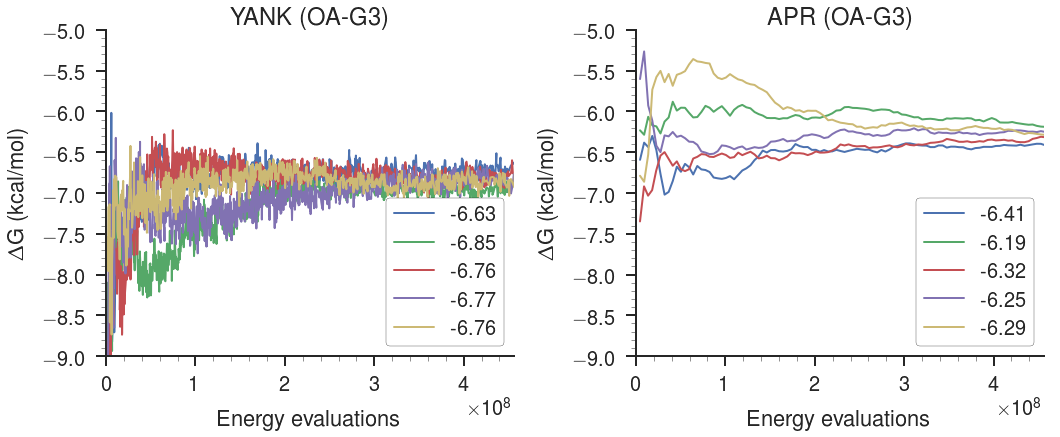

In [73]:
colors("OA-G3", (-9, -5))

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:638: UserWarning: Unrecognized location "bottom left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


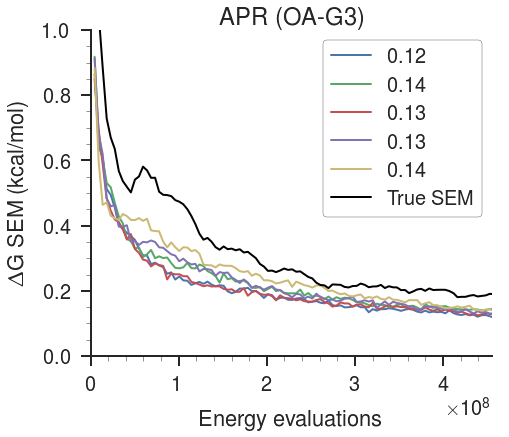

In [74]:
colors_sem("OA-G3", (0, 1.0))

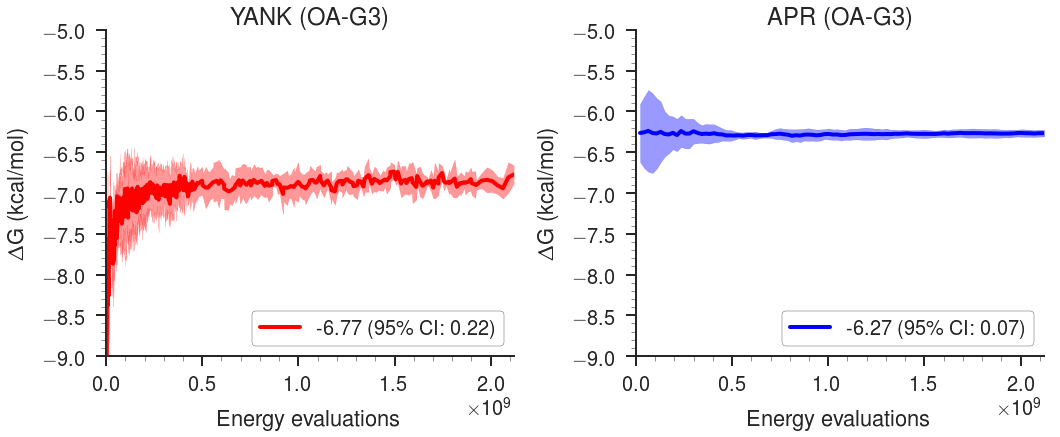

In [235]:
means("OA-G3", (-9, -5))

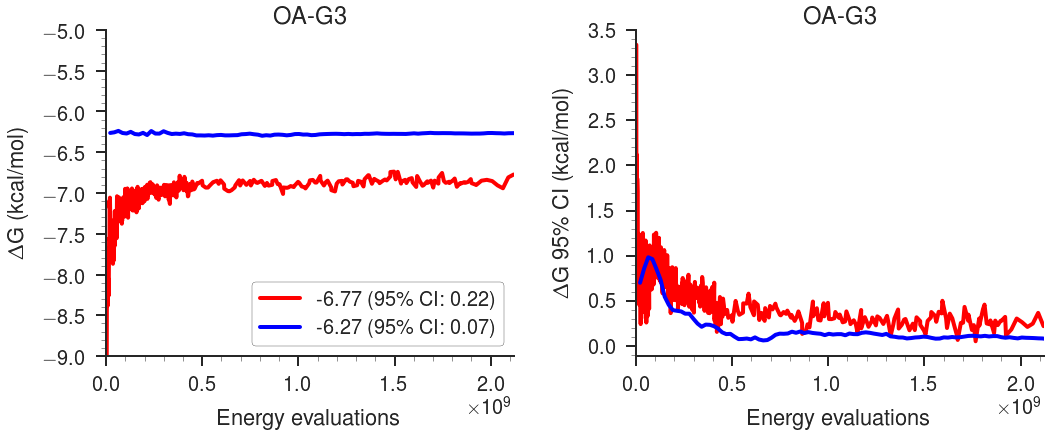

In [236]:
simple_means("OA-G3", (-9, -5))

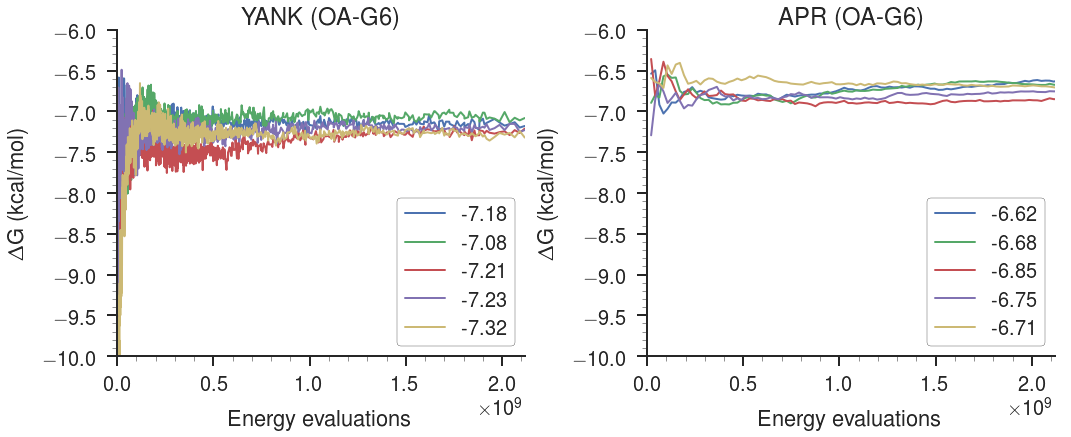

In [237]:
colors("OA-G6", (-10, -6))

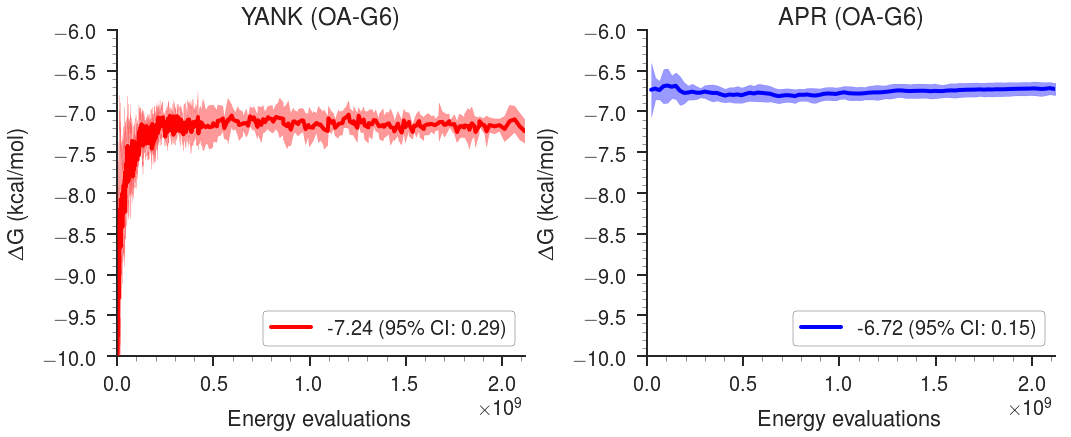

In [238]:
means("OA-G6", (-10, -6))

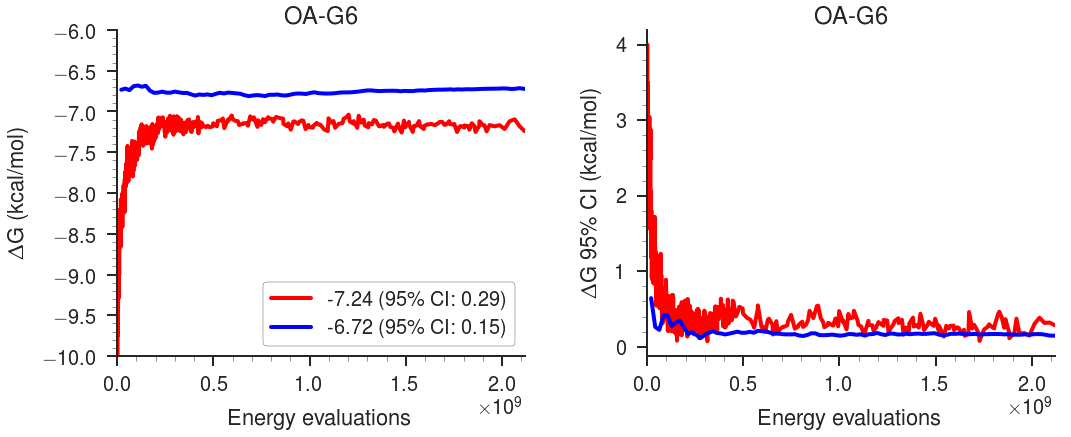

In [239]:
simple_means("OA-G6", (-10, -6))

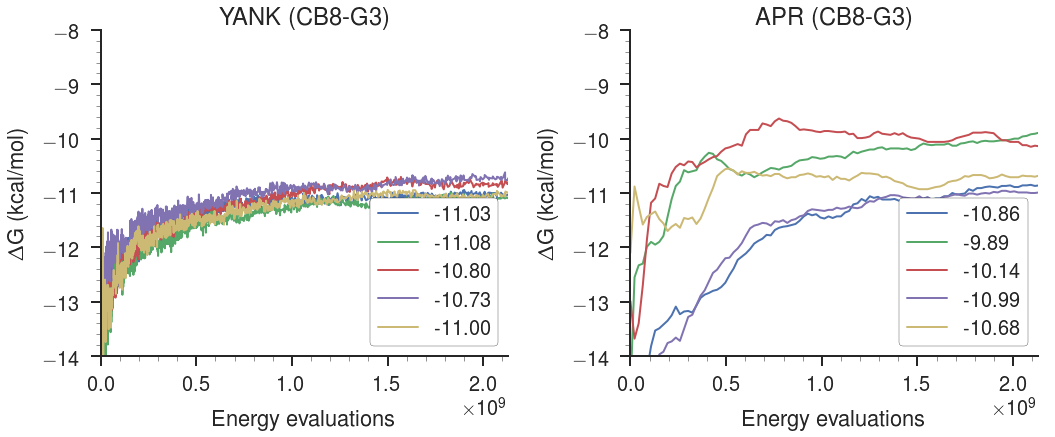

In [196]:
colors("CB8-G3", (-14, -8))

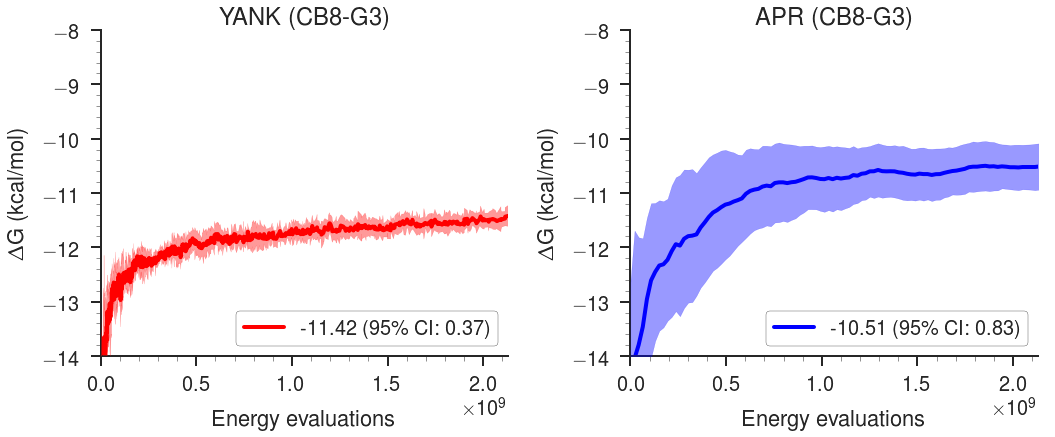

In [197]:
means("CB8-G3", (-14, -8))

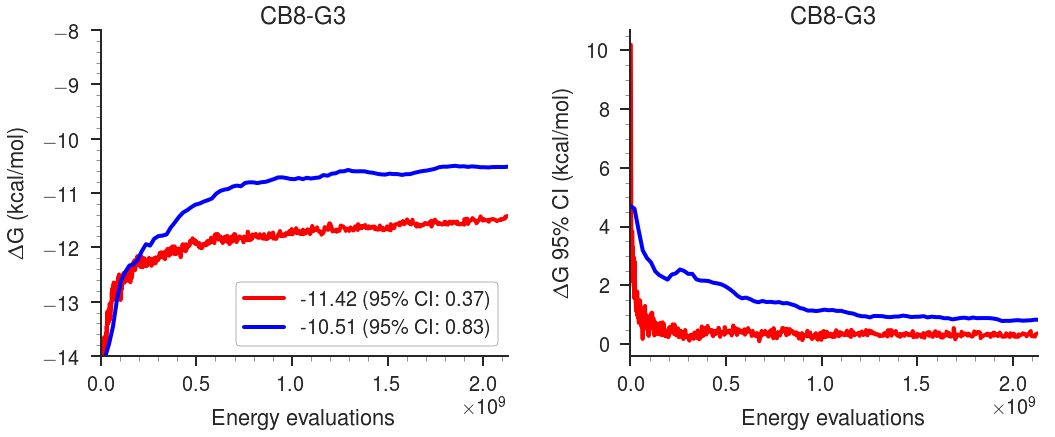

In [208]:
simple_means("CB8-G3", (-14, -8))